# Introduction to Principal Component Analysis

In this example, we will continue to examine *unsupervised* learning techniques designed to uncover patterns in data when specific labels have not yet been provided for target features. This notebook will cover Principal Component Analysis to examine axes of variance in data.

**Learning Objectives**

1. Describe the goals of PCA 
2. Outline the steps to perform PCA
3. Interpret the results of PCA

**Import modules**

Begin by importing the modules to be used in this notebook

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc4
from scipy import linalg
from scipy.interpolate import griddata
from scipy.signal import detrend

Matplotlib is building the font cache; this may take a moment.


## Motivation
Often, we are confronted with data sets with many dimensions or variables, and we're interested in pulling key information from the overall data set. If we assume that the key information is reflected in the variance of the data, then we can apply Principal Component Analysis (PCA) to identify this information. In this unsupervised learning approach, we apply a transformation to our data to find the hidden axes that describe the greatest amount of variance. The resulting axes may not represent a meaningful unit (in terms of the original units of the data) but they do give us a starting point for discovering the important patterns in our data. To make this more concrete, let's take a look at a simple 2-dimensional example.

## An Example Data Set: Coastal Winds

In this notebook, we are going to investigate patterns in wind variablity on the ocean surface. Let's have a look at wind measurements from an oceanographic buoy off the coast of California near Monterey Bay. The following map shows the location of this buoy:

<img src="Monterey Buoy Map.png" alt="Location of buoy 46042" width="500">

First, let's identify a file for this data:

In [2]:
ncfile = 'https://dods.ndbc.noaa.gov/thredds/dodsC/data/stdmet/46042/46042h2020.nc'
#ncfile = '46042h2020.nc'

Then, we can read in the wind data from this buoy using the `netCDF` package.:

In [3]:
ds = nc4.Dataset(ncfile)
wind_speed = ds.variables['wind_spd'][:][:,0,0]
wind_direction = ds.variables['wind_dir'][:][:,0,0]
ds.close()

In [4]:
# remove some missing values
indices = np.isreal(wind_speed) & np.isreal(wind_direction)
wind_speed = wind_speed[indices]
wind_direction = wind_direction[indices]

Let's have a look at the wind data we read in:

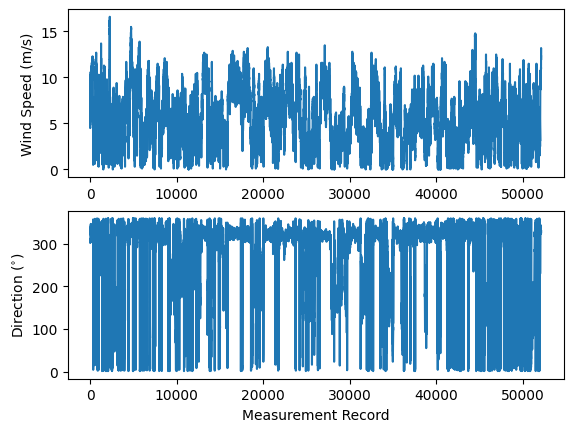

In [5]:
plt.subplot(2,1,1)
plt.plot(wind_speed)
plt.ylabel('Wind Speed (m/s)')
plt.subplot(2,1,2)
plt.plot(wind_direction)
plt.ylabel('Direction ($^{\\circ}$)')
plt.xlabel('Measurement Record')
plt.show()

Note that there is one measurement produced from this buoy approximately every 10 minutes. Wind speed and direction, as shown above, may be a convenient format for mariners but for analysis, it is more convenient to work with wind as a vector i.e. in terms of the northward and eastward components. We can make this conversion with the following bit of trigonometry:

In [6]:
theta = np.array(wind_direction) # direction CW from true north
theta = theta*np.pi/180. # convert to radians
theta_cart = np.arctan2(np.cos(-theta),-np.sin(-theta)) # direction CCW from east (Cartesian)
u = -wind_speed*np.cos(theta_cart) # eastward component
v = -wind_speed*np.sin(theta_cart) # northward component

Let's have a look at the directional components:

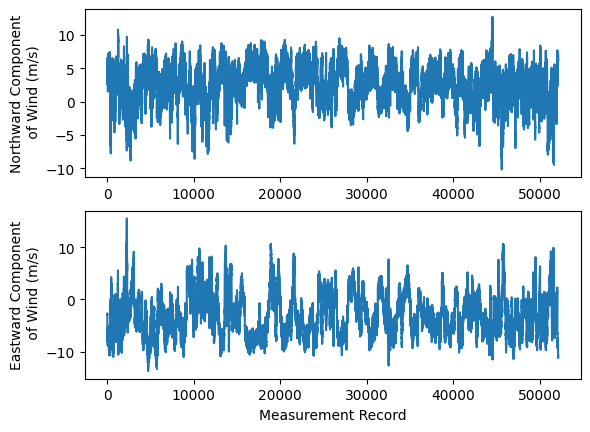

In [7]:
plt.subplot(2,1,1)
plt.plot(u)
plt.ylabel('Northward Component\n of Wind (m/s)')
plt.subplot(2,1,2)
plt.plot(v)
plt.ylabel('Eastward Component\n of Wind (m/s)')
plt.xlabel('Measurement Record')
plt.show()

We can see in the map above that there is a lot of variability in the wind speed in both directions. We can also visualize this on a map:

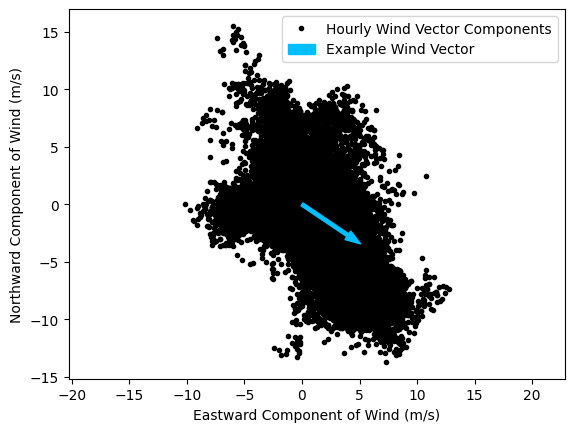

In [8]:
plt.figure()
plt.plot(u,v,'k.',label='Hourly Wind Vector Components')

example_index = 5 # change to see other examples
plt.arrow(0,0,u[example_index],v[example_index],
          color='deepskyblue',zorder=99, width=0.3,label='Example Wind Vector')

plt.xlabel('Eastward Component of Wind (m/s)')
plt.ylabel('Northward Component of Wind (m/s)')
plt.legend()
plt.axis('equal')
plt.show()

In the example data, we might be interested in the following question: *what is the wind speed in the direction that wind blows the strongest*? Oceanographically, this is an important question because winds tend to be steered along the coastline - and coastally-aligned winds are associated with upwelling or downwelling in the California Current systems.

If we phrase this question as a data science question, we might alternatively ask: **what is the variance along the axis of highest variance in this data set?**

## Principal Component Analysis

In Principal Component Analysis (PCA), we compute the axes of strongest variance in a given set of data as well as how much of the total variability this axis accounts for. This is done in a simple recipe using a few tools from Linear Algebra:

### The PCA Recipe

The steps for PCA are as follows:
- Step 0: Formulate a data matrix $X$ which is size $(N, M)$
- Step 1: Compute the Covariance Matrix of $X$
- Step 2: Compute Eigenvalues and Eigenvectors

Let's see how this works for our wind example:

### Step 0: Create a Data Matrix
For principal component analysis, begin by computing the $(N, M)$ data matrix. In this case, $N$ corresponds to each wind observation while $M$ corresponds to each wind direction - the eastward and northward directions in this case.

In [9]:
# create the data matrix
X = np.column_stack([u,v])

Typically, you would also be advised to standardize your data in the case your data columns pertained to different types of variables. However, since we are working with wind speed in both components, we will use the raw data in this example.

### Step 1: Compute the Covariance Matrix
Up next, we will compute the covariance matrix $C$. The covariance matrix has entries as that correspond to the covariance of each component of the timeseries, i.e. on row $i$ and column $j$, we compute

$$
C_{i,j} = \frac{1}{N} \sum_{n=1}^N (X_i - \overline{X_i})(X_j - \overline{X_j})
$$

Here, the $\overline{\cdot}$ operator indicates the mean and $X_i$ indicates the $i$th column of the design matrix $X$. Since there are $M$ columns in $X$, the covariance matrix has shape $(M, M)$.

We can use numpy's `cov` function to compute the covariance matrix:

In [10]:
# enter code for the covariance matrix here
C = np.cov(X, rowvar=False)

In [11]:
# sanity check that the plot has the correct dimensions
print(C)

[[ 8.14200067 -7.671079  ]
 [-7.671079   15.61942835]]


### Step 2: Compute Eigenvalues and Eigenvectors
In the final step of the PCA procedure, we compute the eigenvalues ($\lambda_i$'s) and eigenvectors ($\textbf{v}_i$'s) of the covariance matrix. An eigenvalue is a vector that does not change, up to a constant, when a linear transformation is applied to it. In other words, the multiplication of this vector by a tranformation $A$ is the same as multiplying by a constant:

$$
A\textbf{v}_i = \lambda_i\textbf{v}_i
$$

We can use numpy's `linalg` package to compute these eigenvalues:

In [12]:
# enter code to compute the values and vectors 
values, vectors = linalg.eig(C)

In general, eigenvalues and eigenvalues can have complex values, so let's take only the real parts of these values:

In [16]:
# sanity check that the values are real
values = np.real(values)

# print out the values
print(values)

[ 3.34704975 20.41437927]


Depending on your calculations, the eigenvalues may or may not be sorted in descending order. Typically, we would like to sort our values and their corresponding vectors so that we can see which axes are responsible for the highest variance. Let's apply a quick sort to be sure:

In [17]:
sorted_indices = np.argsort(values)[::-1]
values = values[sorted_indices]
vectors = vectors[:, sorted_indices]

In [18]:
# print the values to ensure they are in descending order
print(values)

[20.41437927  3.34704975]


### Interpreting PCA Results

In the steps above, we recovered two important pieces of information. The first piece is our eigenvectors - as mentioned above, these tell us about the dominant axes of variablity in in our data. Be default, these are scaled to have length 1. The eigenvalues give us a quantification of the variance along the axes identified by the eigenvectors - in effect, they give us the magnitude of our eigenvectors. We can quantify this information for our two vectors below.

First, we compute the variance explained:

In [22]:
# compute the variance explained
variance_explained = 100 * values / np.sum(values)

Then, we can provide some stats for our vectors:

In [23]:
print(f'The first eigenvector has values [{vectors[0][0]}, {vectors[1][0]}]')
print(f'This eigenvector has length {values[0]**0.5} and explains {variance_explained[0]:.2f}% of the variance.')

The first eigenvector has values [0.5300407944353716, -0.8479721435485487]
This eigenvector has length 4.518227448066794 and explains 85.91% of the variance.


In [24]:
print(f'The second eigenvector has values [{vectors[0][1]}, {vectors[1][1]}]')
print(f'This eigenvector has length {values[1]**0.5} and explains {variance_explained[1]:.2f}% of the variance.')

The second eigenvector has values [-0.8479721435485487, -0.5300407944353716]
This eigenvector has length 1.8294943971106992 and explains 14.09% of the variance.


Let's go ahead and plot these vectors below to see how they compare to the wind vectors:

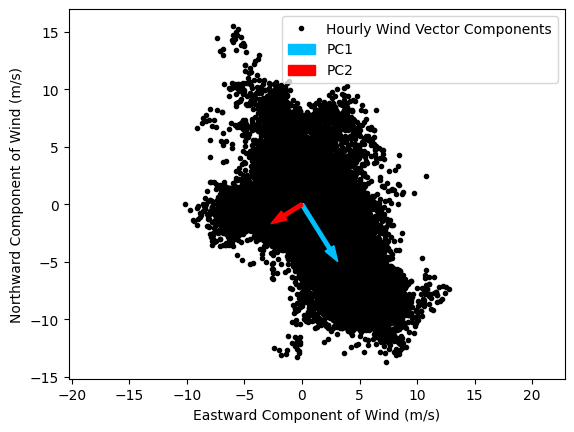

In [28]:
plt.figure()
plt.plot(u,v,'k.',label='Hourly Wind Vector Components')

# plot the first principal component
plt.arrow(0,0,vectors[0][0] * np.sqrt(values[0]), vectors[1][0] * np.sqrt(values[0]),
          color='deepskyblue',zorder=99, width=0.3,label='PC1')

# plot the second principal component
plt.arrow(0,0,vectors[0][1] * np.sqrt(values[1]), vectors[1][1] * np.sqrt(values[1]),
          color='red',zorder=99, width=0.3,label='PC2')


plt.xlabel('Eastward Component of Wind (m/s)')
plt.ylabel('Northward Component of Wind (m/s)')
plt.legend()
plt.axis('equal')
plt.show()

As we can see above, the first vector with the highest explained variance - the first principal component - is directed along the axis where wind variability is strongest. The other principal component is *orthogononal* to the first principal component and described by the other axis of variability. 

### Amplitude of the Principal Components
The amplitude of the principal components allow us to investigate the variability along our identified axes of variablity. This amplitude matrix is computed as

$$
\tau = XV
$$

where $V$ is the eigenvector matrix. The principal components are the columns of this matrix and correspond to our data projected onto each of the axes of variance. Let's see what this looks like for our wind timeseries:

In [31]:
# compute tau
tau = np.dot(X, vectors)

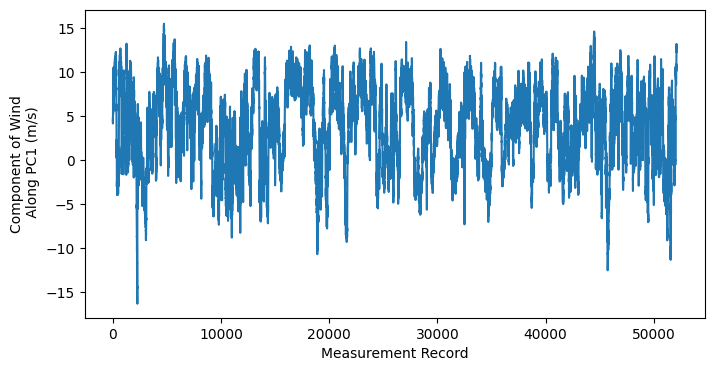

In [32]:
plt.figure(figsize=(8,4))
plt.plot(tau[:,0])
plt.ylabel('Component of Wind\n Along PC1 (m/s)')
plt.xlabel('Measurement Record')
plt.show()

One way to interpret this time series is to consider yourself standing on top of the buoy. Then, turn so that you are facing in the direction identified by PC1. This timeseries shows the wind you would feel directly against your back.

## &#129300; Check Your Understanding

Consider the following questions to check your understanding of the 

**1. What is the variance of the first principal component?**

Compute that here:

In [33]:
# compute the variance of the first principal component
np.var(tau[:,0])

np.float64(20.41398747936807)

Where else do we see this value in our calculations above?

**2. How does the magnitude of wind along the second principal component compare to the first?**

Make a plot of that here:

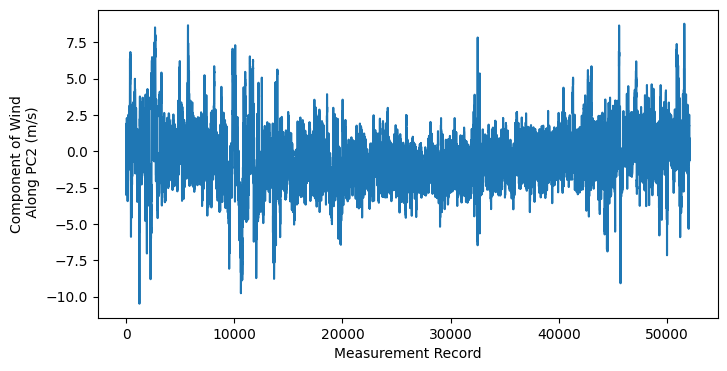

In [34]:
# make a plot of PC2
plt.figure(figsize=(8,4))
plt.plot(tau[:,1])
plt.ylabel('Component of Wind\n Along PC2 (m/s)')
plt.xlabel('Measurement Record')
plt.show()

What is the variance of this timeseries and where else do we see this value in our calculations?

In [35]:
# compute the variance of the second principal component
np.var(tau[:,1])

np.float64(3.3469855124267123)

**3. What is the variance of wind *speed* computed from *u* and *v*?**

Compute wind speed from $u$ and $v$, and then compute the variance of wind speed in this time series:

In [37]:
# compute wind speed from u and v
wind_speed_uv = np.sqrt(u**2 + v**2)

np.var(wind_speed_uv)

np.float64(8.623632600721479)

How do you expect this to compare to the variance of wind speed as computed from PC1 and PC2?

In [38]:
# compute wind speed from PC1 and PC2
wind_speed_PC = np.sqrt(tau[:,0]**2 + tau[:,1]**2)

# compute the variance of this quantity
np.var(wind_speed_PC)

np.float64(8.62363260072148)

**Key Takeaways**

1. Principal component analysis computes the axes of variablity in a data set 
2. The eigenvectors of the covariance matrix represent these axes while the eigenvalues provide the variance values
3. The principal components are the projections of the data along the axes of variability

**References**

Note: this example was inspired by Tom Connolly's data analysis course notes on PCA [HERE](https://mlmldata2022.github.io/course-notes/week09c-ndbc-wind.html).